In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style = "ticks")

# Introduction

In this research project I am investigating a Dataset from https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction.

According to the source, the data was obtained by using Octoparse scraping tool to extract data from the website. Data was collected in two parts: one for economy class tickets and another for business class tickets. A total of 300261 distinct flight booking options was extracted from the site. Data was collected for 50 days, from February 11th to March 31st, 2022. Data source was secondary data and was collected from Ease my trip website.

The description of the features of the dataset is below:

The various features of the cleaned dataset are explained below:

1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.

2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.

3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.

4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.

6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.

7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.

8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.

9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.

10) Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.

11) Price: Target variable stores information of the ticket price.

I have chosen this dataset, since I had a personal interest, on how price of the ticket is affected by various conditions. I could not find a dataset from Kazakhstan myself, thus I will investigate this data set

In this part of my project I am choosing as a target value "price" and I will predict it using following models: Linear Regression, Polynomial Regression, Random Forests

# Data Preprocessing

In [2]:
df = pd.read_csv("Clean_Dataset.csv")
df.drop("Unnamed: 0",axis = 1, inplace = True)
df["stops"] = df["stops"].map({"zero":0,
                              "one":1,
                              "two_or_more":2})
df["class"]=df["class"].map({"Economy": 0,
                            "Business": 1})

In [3]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,0,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,0,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,0,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,0,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,0,2.33,1,5955


### Dropping multicollinear variables

In [506]:
def check_multicollinearity(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    variables = df[['stops','departure_time_Early_Morning',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night', 'duration','days_left']]
    variables2 = df[['departure_time_Early_Morning',
       'departure_time_Evening', 'departure_time_Late_Night',
       'departure_time_Morning', 'departure_time_Night', 'duration','days_left']]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif["features"] = variables.columns
    vif2 = pd.DataFrame()
    vif2["VIF2"] = [variance_inflation_factor(variables2.values, i) for i in range(variables2.shape[1])]
    vif2["features"] = variables2.columns
    display(vif)
    display(vif2)
    
check_multicollinearity(pd.get_dummies(df))
## This function checks multicollinearity within the variables.
## Especially, I wanted to check, if there is any relation between "stops" variable and others.
## Also, I wanted to check whether departure time is correleated with duration of flight and days left, since by my 
## intuition, departure time is also a variable which affects flight price, and I want to use it in the regression

,VIF,features
0,6.613241,stops
1,1.843926,departure_time_Early_Morning
2,1.870681,departure_time_Evening
3,1.013895,departure_time_Late_Night
4,1.914677,departure_time_Morning
5,1.663872,departure_time_Night
6,5.250487,duration
7,3.564371,days_left


,VIF2,features
0,1.740195,departure_time_Early_Morning
1,1.838916,departure_time_Evening
2,1.012805,departure_time_Late_Night
3,1.766223,departure_time_Morning
4,1.652066,departure_time_Night
5,3.211049,duration
6,3.207548,days_left


Here we can see, that "stops" is correlated to some variables, since it has Variance Inflation Factor bigger than 5. Thus I will not include "stops" in my models. Also, I will drop arrival time, since there should be correlation between "departure time" "duration" and "arrival time", as "arrival time" results from "departure time" + "duration". Thus, "arrival time" variable will be dropped from the dataset, and will not be used in my models.

In [507]:
cols_drop = ['flight', 'source_city', 'arrival_time','destination_city','stops']
df = df.drop(cols_drop,axis = 1)

### Log transform of variables

Text(0.5, 1.0, 'Log Price')

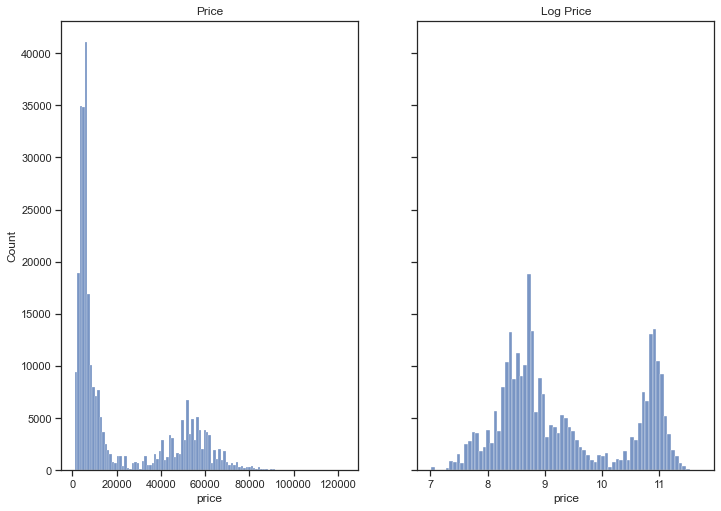

In [508]:
fig,axes = plt.subplots(1,2,sharey = True) 
sns.histplot(df["price"],ax = axes[0]).set_title("Price")
sns.histplot(np.log(df["price"]),ax = axes[1]).set_title("Log Price")

Text(0.5, 1.0, 'Log Duration')

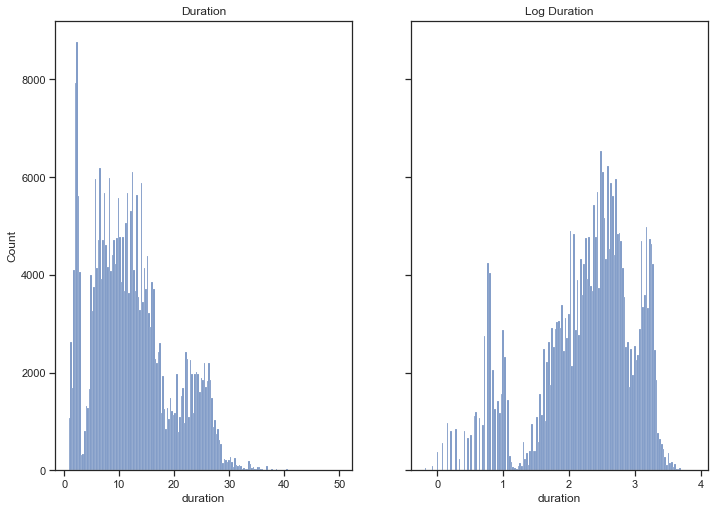

In [509]:
fig,axes = plt.subplots(1,2,sharey = True) 
sns.histplot(df["duration"],ax = axes[0]).set_title("Duration")
sns.histplot(np.log(df["duration"]),ax = axes[1]).set_title("Log Duration")

Here we can see, that we have two peeks, lower one for economy class, and higher is for business class. With log transform, their distributions look "bell-shaped" and thus, in my models I will use log(price)

For "duration" variable, log transform does not really change much. Thus we will keep "duration" as usual.

In [510]:
log_price = np.log(df["price"])
df_with_dummies['log_price'] = log_price
df['log_price'] = log_price
df = df.drop("price",axis = 1)
df.head()

,airline,departure_time,class,duration,days_left,log_price
0,SpiceJet,Evening,0,2.17,1,8.691651
1,SpiceJet,Early_Morning,0,2.33,1,8.691651
2,AirAsia,Early_Morning,0,2.17,1,8.692154
3,Vistara,Morning,0,2.25,1,8.691986
4,Vistara,Morning,0,2.33,1,8.691986


### Outlier detection

<AxesSubplot:>

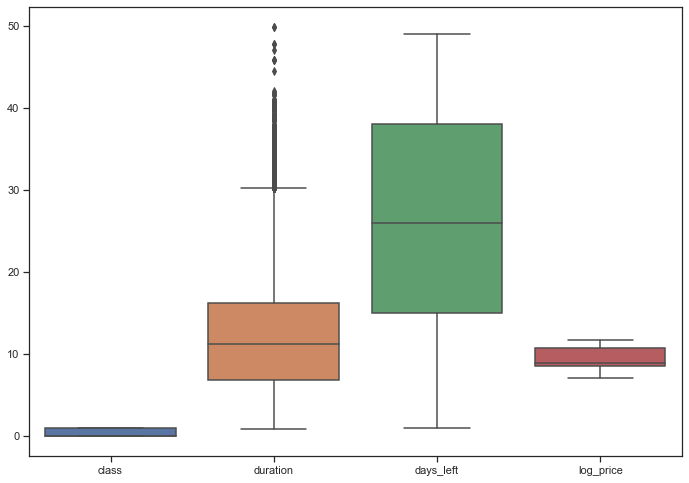

In [511]:
sns.boxplot(data = df)

We see that in "duration we have several outliers with flight duration more than 30, now we want to what is the propotion of these variables.

In [512]:
len(df[df["duration"]>30])/len(df)

0.007416217728958232

We have 0.7% of data which are the outliers. We can safely remove them, since they could affect my models.

In [513]:
df = df[df["duration"]<30]
df = df.reset_index(drop = True)

<AxesSubplot:>

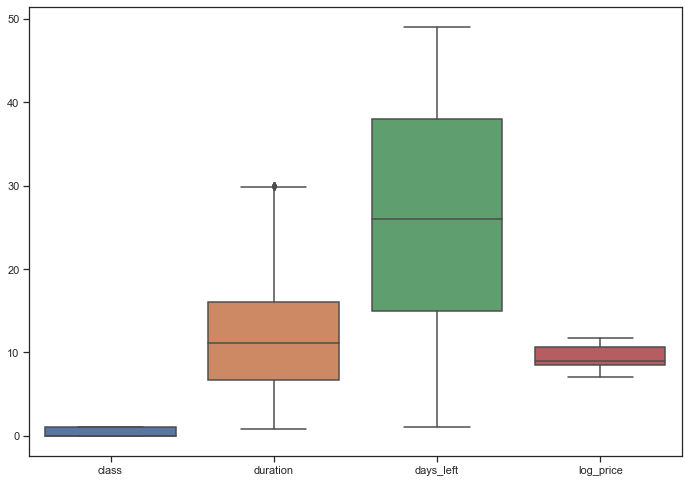

In [514]:
sns.boxplot(data = df)

We have some more outliers more than ~29. We will count how many

In [515]:
len(df[df["duration"]>29])/len(df)

0.002293269941039795

The propotion is about 0.22%. We can drop them too, unless we have no outliers.

In [516]:
df = df[df["duration"]<29]
df = df.reset_index(drop = True)

<AxesSubplot:>

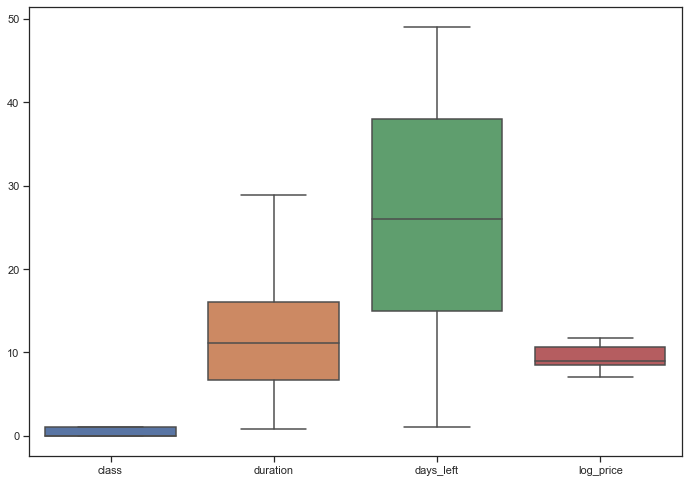

In [517]:
sns.boxplot(data = df)

Now we may proceed further

### Creating Dummies

In [518]:
df_with_dummies = pd.get_dummies(df,drop_first = True)
df_with_dummies ### This is our finished dataset.

,class,duration,days_left,log_price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
0,0,2.17,1,8.691651,0,0,0,1,0,0,1,0,0,0
1,0,2.33,1,8.691651,0,0,0,1,0,1,0,0,0,0
2,0,2.17,1,8.692154,0,0,0,0,0,1,0,0,0,0
3,0,2.25,1,8.691986,0,0,0,0,1,0,0,0,1,0
4,0,2.33,1,8.691986,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297087,1,10.08,49,11.145695,0,0,0,0,1,0,0,0,1,0
297088,1,10.42,49,11.252923,0,0,0,0,1,0,0,0,0,0
297089,1,13.83,49,11.278456,0,0,0,0,1,1,0,0,0,0
297090,1,10.00,49,11.309401,0,0,0,0,1,1,0,0,0,0


After creation of dummy variables, the categorical data has the following properties.

For "airline" dummies, the respective benchmark is "airline AirAsia"

For "departure_time" dummies, the respective benchmark is  "departure_time Afternoon"

For "class" dummies, 0 means economy, and 1 is business.

### Independent and Dependent variables

In [519]:
X = df_with_dummies.drop("log_price",axis = 1)
y = df_with_dummies["log_price"]


### Train Test Split

I will split the data into 90/10 test split. I will use 90% proportion of the data with cross-validation, to train and tune the model. Then, remaining 10% will be used for test.

In [520]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 1
                                                   ,test_size= 0.1)

# Methods & Experiments

_______________________________________________________________________________________________________________________________

# Linear Regression

In [400]:
def LinRegCrossValidation(X,y):
    
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size= 0.1)
    reg = LinearRegression()
    cv_scores = cross_val_score(reg,X_train,y_train,cv = 9)
    return cv_scores.mean()

LinRegCrossValidation(X,y)

0.8944881745910421

In general, Linear Regression without any other parameters performs well on this dataset. Now let's test it

In [403]:
def LinRegSummaryTable(X,y):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size= 0.1)
    
    reg = LinearRegression().fit(X_train,y_train)
    r2 = reg.score(X_test,y_test)
    adj_r2 = 1-(1-r2)*(len(X_test)-1)/(len(X_test)-len(X_test.columns)-1) ##calculating adjusted r2
    features = list(X.columns.values)
    features.append("Intercept")
    vals = list(reg.coef_)
    vals.append(reg.intercept_)

    weights_summary = pd.DataFrame(features, columns = ["Features"])
    weights_summary["Weights"] = vals
    display(weights_summary)

    statistics =  ['r2','adj r2','cv-9fold score']
    reg_summary = pd.DataFrame(statistics,columns=["Metrics"])
    reg_summary["Values"] = [r2,adj_r2,cross_val_score(reg,X_train,y_train,cv = 9).mean()]
    display(reg_summary)

LinRegSummaryTable(X,y)

,Features,Weights
0,class,2.022500
1,duration,0.016869
2,days_left,-0.014301
3,airline_Air_India,0.431915
4,airline_GO_FIRST,0.382605
5,airline_Indigo,0.274225
6,airline_SpiceJet,0.349537
7,airline_Vistara,0.585408
8,departure_time_Early_Morning,-0.011404
9,departure_time_Evening,-0.076519


,Metrics,Values
0,r2,0.895536
1,adj r2,0.895490
2,cv-9fold score,0.894488


### Residuals Distribution plot

(0.0023716688452758684, 0.12904332747638458)

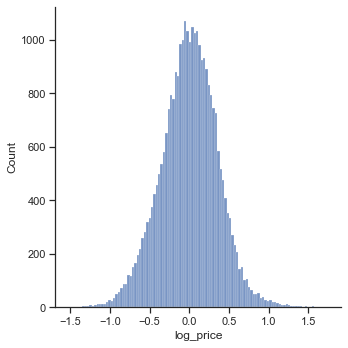

In [561]:
def LinRegResidualsPlot(X,y):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1 ,test_size= 0.1)
    
    reg = LinearRegression().fit(X_train,y_train)
    y_hat = reg.predict(X_test)
    e = y_test-y_hat
    sns.displot(e)
    return (e.mean(),e.var())

LinRegResidualsPlot(X,y)

We see that residuals displot follows a normal distribution with a mean around 0. This is an indicator of a good model.
However, right tail is slightly taller than the left one. This can be interpreted, that our model underfits the data to a very small extent. But this is very very very very small.

### Dummy Regressor evaluation

In [408]:
def LinRegDummyEvaluation(X,y):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.dummy import DummyRegressor
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1 ,test_size= 0.1)
    
    reg = LinearRegression().fit(X_train,y_train)
    reg_dummy = DummyRegressor(strategy= "mean").fit(X_train,y_train)
    reg_dummy.score(X_test,y_test)
    return (reg_dummy.score(X_test,y_test),reg.score(X_test,y_test))
LinRegDummyEvaluation(X,y)

(-8.972578509069962e-07, 0.8955358794275738)

For a dummy regressor, we chose the mean strategy as a benchmark. As expected, it's R2 value is near 0. 
We assume that our model performed well on test data, since its R2 and Adj R2 are high. Moreover, by cross validation, the mean r2 value is around ~89.5, which is a good result.

### Discussion

Linear Regression is one of the simplest models can be trained, thus it is very unlikely that it will overfit the data. Also, according to the Residual analysis, our model underfits our data to a very small extent. I personally believe, that use of Ridge and Lasso Regression would not give a significant change to the test score, since they are designed to add regularization parameter to prevent overfitting, which is very unlikely in this case. Moreover, as we have 270 000 points in our training data, the regularization is not needed. Since we're using a simple Linear Model, I want to investigate, how more complex models would perform on this dataset


_______________________________________________________________________________________________________________________________

# Polynomial Regression

In [496]:
def PolynomialRegression(X,y,n):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    


    poly = PolynomialFeatures(degree=n)
    X_poly = poly.fit_transform(X)
    X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y,random_state=1,test_size=0.2)
    reg_poly = LinearRegression().fit(X_poly_train,y_train)
    return (reg_poly.score(X_poly_train,y_train),reg_poly.score(X_poly_test,y_test))

print(PolynomialRegression(X,y,2),PolynomialRegression(X,y,3))

(0.9283831088102623, 0.9283926889006723) (0.9384459384815035, 0.938258680127186)


With Polynomial Linear Regression of degree 2, the R2 has increased dramatically from 0.895 to 0.928 on test sample.

With Polynomial Linear Regression of degree 3, the R2 is ~0.938 for both train and test samples.

Note: R2 scores of Polynomial Linear Regression of degree 2 and 3 with (train,test) scores with 80/20 split

In [489]:
def PolynomialCV(X,y,n):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=n)
    X_poly = poly.fit_transform(X)
    X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y,random_state=1,test_size=0.1)
    reg_poly = LinearRegression()
    cv_scores = cross_val_score(reg,X_poly_train,y_train,cv = 9)
    return (cv_scores.mean(),[cv_scores])

PolynomialCV(X,y,2)

(0.928267550740448,
 [array([0.92777172, 0.9284434 , 0.92807625, 0.92758464, 0.9276993 ,
         0.9283867 , 0.92841106, 0.92848981, 0.92954508])])

Cross-Validation score of a Polynomial Linear Regression model (9-fold) of degree 2

In [490]:
PolynomialCV(X,y,3)

(0.9382934155158252,
 [array([0.93783224, 0.93823382, 0.93792699, 0.93767144, 0.93802898,
         0.93846501, 0.93844399, 0.93825557, 0.9397827 ])])

Cross-Validation score of a Polynomial Linear Regression model (9-fold) of degree 3

In [493]:
#scores = []
#degree = np.linspace (2,10,9)
#for n in degree:
    #scores.append(PolynomialCV(X,y,degree))
#scores
    

### WARNING:
Uncomment the code above for your own risk!
These lines are computationally expensive, since we already have 13 explanatory variables. With polynomials features, their amount increases dramatically. The code above computes 9-fold cross validations for the polynomial linear regressions with degrees from 2 to 10.

### Residual Analysis

In [559]:
def PolynomialResidualsPlot(X,y,n):
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import PolynomialFeatures
        
    poly = PolynomialFeatures(degree=n)
    X_poly = poly.fit_transform(X)
    X_poly_train,X_poly_test,y_train,y_test = train_test_split(X_poly,y,random_state=1,test_size=0.2)
    reg_poly = LinearRegression().fit(X_poly_train,y_train)
    
    y_hat = reg_poly.predict(X_poly_test)
    e = y_test-y_hat
    sns.displot(e)
    return (e.mean(),e.var())



((0.0010776448773123647, 0.0883624264178882),
 (0.0021391569736483314, 0.0761843556608724))

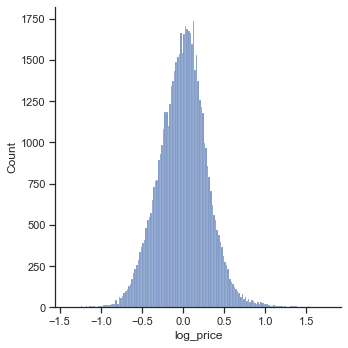

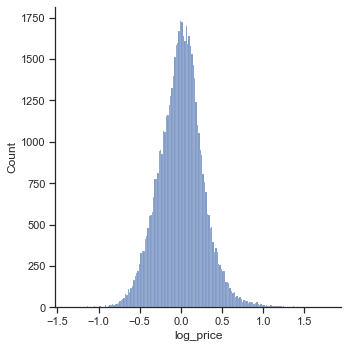

In [560]:
(PolynomialResidualsPlot(X,y,2),PolynomialResidualsPlot(X,y,3))

_______________________________________________________________________________________________________________________________

# Random Forests

In [615]:
def RandomForestReg(X,y,n):
    from sklearn.model_selection import train_test_split    
    from sklearn.ensemble import RandomForestRegressor
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1 ,test_size= 0.1)
    
    reg_forest = RandomForestRegressor(n_jobs= -1,n_estimators = n).fit(X_train,y_train)
    return (reg_forest.score(X_train,y_train),reg_forest.score(X_test,y_test))
RandomForestReg(X,y,100)


(0.9804634854896344, 0.9499072996126644)

Quite impressive train and test score. Now we perform cross-validation to validate the model.

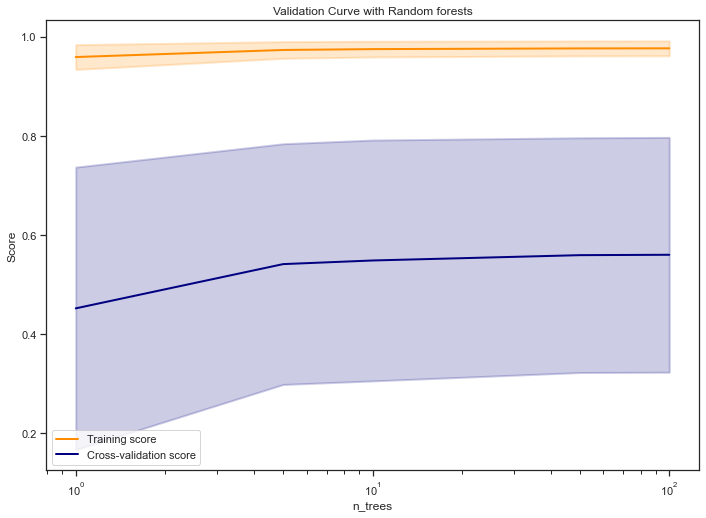

(array([[0.97404466, 0.97447993, 0.97131357, 0.91559559],
        [0.98309422, 0.98379081, 0.98153967, 0.94396058],
        [0.98421566, 0.98497968, 0.98279824, 0.9474402 ],
        [0.98509255, 0.98589619, 0.98381342, 0.95022262],
        [0.98520933, 0.98600414, 0.98394349, 0.950557  ]]),
 array([[0.42175013, 0.41297339, 0.8866866 , 0.08740283],
        [0.5220292 , 0.51879189, 0.90426716, 0.2205411 ],
        [0.53394865, 0.53398673, 0.90618184, 0.220769  ],
        [0.54234652, 0.54759954, 0.90794919, 0.2399811 ],
        [0.54409607, 0.54858089, 0.90832797, 0.23988024]]))

In [618]:
def RandomForestCV(X,y):
    from sklearn.model_selection import validation_curve
    from sklearn.ensemble import RandomForestRegressor
    
    param_range = [1,5,10,50,100]
    train_scores, test_scores = validation_curve(
        RandomForestRegressor(),
        X, y, param_name = "n_estimators",
        param_range=param_range,
        cv = 4,
        n_jobs = -1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with Random forests")
    plt.xlabel("n_trees")
    plt.ylabel("Score")
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()
    return (train_scores,test_scores)
RandomForestCV(X,y)

What a poor performance. There is a clear evidence of overfitting the model, since the training accuracy is about 1, while test performance is very low. The reason of this poor performance will be discussed in the error analysis section

# Analysis & Error propogation

## Linear Regression

Linear Regression is one of the quickest, computationally fastest and simplest models available in the hands of a Data-Scientist. In my 1-st part of this project I have highlighted that the Ceteris Paribus effects of several variables to some extent follow a linear model, which was nearly approximate to the local regression plot I have presented there. In this dataset, with a nearly 270 000 points of training data, I believe, that linear model showed a good performance.

From the summary table I have generated below the regression model, we may draw several conclusions on the effect of the variables on the price of the ticket, and they will be discussed in the discussion part.

Talking about model performance itself, I consider a adj_R2 value of ~0.895 quite impressive considering model's mathematical and computational simplicity. This result is supported by 9-fold cross validation on a test-sample, with averate ~0.894 R2 value.

The imperfectness of the model may be caused by the variabe "duration" and "time left" which I believe, has a polynomial effect on the price, since the relationship between 'price' and 'duration' was not linear in project-1.

Finally, I believe, that Linear Model slightly underfits the data, since in the distribution of residuals I have found that there is a slightly taller right tail, which means more of the estimated targets were lower that the actual ones, in comparison to the overestimated ones. But this underfitting is very small, since residuals visually looks like a bell-shaped figure.

I would suggest using Shapiro's test to check it.

### Error Propogation

Since there are possible varialbes with non-linear relationship with target variable, it caused decrease in the performance of the model. Additionally, there is no need in the regularization parameters, since the amount of observations in the dataset is enough to use parameters without regularization.


## Polynomial Regression

In order to support my hypothesis from the Linear Model, that some variables (most likely "duration" and "time left") do have non-linear relationship with the target variable. After performing model training on a 2-degree polynomial features, we have found that it's mean R2 value increased up to ~0.928 in a 9-fold cross-validation on a train sample. Calculating score of a test sample performance, it is roughly the same as in the training set. I believe, that the polynomial regression explains most of the data even better, if not the most. 

Additionally, I have checked scores for the degree-3 polynomial regression, and obtained a 0.01 increase in the 9-fold validation score. I assume, that 2-4 degree polynomial features would imply the best performance of the model, however, I could not test 4-degree polynomial, as it's computational costs would be to high.

In my opinion, 2-degree polynomial would be the best option, considering huge increase in computational time, vs small increase in precision. So with 2-degree polynomial feauteres, I can obtain high accuracy, while maintaining a good generalization power with computing time.

### Error propogation

In order, to tune the model better, more computational power is needed. There is a possibility of higher degrees of polynomial features which could leave to a better results. Moreover, another approach should be tested, where in the polynomial features should be conitnuous variables only (excluding dummies, categoricals, applying polynomial features transform and including them back in the data set). I believe, this might improve the performance of the model, however, in this case it also may lead into overfitting problem. The problem of overfitting may be overcomed by combining high-degree polynomial features with Ridge/Lasso regression regularization parameters. To conclude, this approach may achieve even more higher performances, but the computational time may increase significantly too.

To conclude, I am satisfied with the results of 2-degree polynomial features regression since it is computationally cheaper, than higher degrees polynomial features. Also, it maintains the simplicity and generality of the model, while achieving high scores in cross-validation and on test sample. Nevetheless, I believe, that there is a space for improvement of this model.

## Random Forests

It can be seen, that upon cross-validation, Random Forests performs the most poor on this dataset. Cross-Validation of this model has shown a clear evidence of over-fitting, with a high train set performance, and very poor on a test set performance. 


### Error propogation
According to the (https://medium.com/swlh/random-forest-fails-a8ca2d46c312#:~:text=Since%20the%20random%20forest%20is,Sparse%20Datasets%20(Zero%20Values)), Random forests perform poor on the two types of datasets:
1) Datasets with linear relationship (Extrapolation Problem)

2) Datasets with a lot of zeros (Sparse Datasets)

I believe, that in the dataset I obtained, there are some linear relationships, and also, since I added a lot of dummies in the model, the presence of zeros in the dataset has made a destructive effect on the performance of the Random forests.

In order, to overcome this problem, I would suggest trying splitting the filter entire dataset with categorical variables, so the remaining dependent variables are duration of the flight and time_left variables only (continuous ones). And then trying to run Random Forests Regression on these datasets, recieving a lot of models which should perform well.

Nevertheless, in my opinion, Random Forests Regression is not a great option on this dataset due to its computational complexity. It has already been shown, that for lower values of n_trees the models performs the worst, however, in case model performs well in the filtered samples of the original dataset with low n_trees, it can be used for the regression. Still, I believe, that linear regression with polynomial features of degrees 2 performed the best both in score and computational time while showing no evidence of overfitting.


# Discussion

Having trained, evaluated and tested three models, I can conclude, that the 2nd model (Linear Regression with polynomial features) performed the best on this data set, as it has good computational time, keeps generality, shows no evidence of overfitting and shows high performance score on the test data set. As a measure of precaution, I have written entire project in the functions, so there is no any data-leakege between the models, since most of the variable names kept the same. Initial analysis of the Variance Inflation Factor allowed me to drop unnecessary variables, while outliers detection helped me to drop outliers which could affect both linear and polynomial regression. As the result, I have obtained results with good performance of models 1 and 2, except for the Random Trees Regression. In the case of Random Trees Regression model, I was suprised, that it could perform so poor, so I am thankful, that I faced this case scenario, as I would not have known it.

Another part of the discussion, is the results interpretation. Since in polynomial i lost a track of variables due to the existence of dummies, I could not interpret the coefficients. In order to have an interpretation of the coefficients, it would be great to work detect which coefficients were multiplied to which, so at the end of the day, there will be information about coefficients and they would be interpretable.

In case of Random Forests, the results are uninterpretable.

In case of the linear model, we have recieved the following results:

In [621]:
LinRegSummaryTable(X,y)

,Features,Weights
0,class,2.022500
1,duration,0.016869
2,days_left,-0.014301
3,airline_Air_India,0.431915
4,airline_GO_FIRST,0.382605
5,airline_Indigo,0.274225
6,airline_SpiceJet,0.349537
7,airline_Vistara,0.585408
8,departure_time_Early_Morning,-0.011404
9,departure_time_Evening,-0.076519


,Metrics,Values
0,r2,0.895536
1,adj r2,0.895490
2,cv-9fold score,0.894488


Since we had a log transform on our target value, we will interpret our results in the following way:

Being in a Business class increases price of the ticket by 202.25%

For each hour of duration of the flight increases price of the ticket by 1.68%

Each day closer to the flight increases price of the ticket by 1.43%

Now speaking about categorical variables, recall that: 

For "airline" dummies, the respective benchmark is "airline AirAsia"

For "departure_time" dummies, the respective benchmark is "departure_time Afternoon"

For "class" dummies, 0 means economy, and 1 is business.

So we may say, that in general, Air India is 43.19% more expensive than Air Asia

GO_First is 38.26% more expensive than Air Asia

Indigo is 27.42% more expensive than Air Asia

SpiceJet is 34.95% more expensive than Air Asia

and Vistara is 59.5% more expensive than Air Asia.

There is a possibility that both Air India and Vista have slightly overestimated coefficients, since there were samples with high prices from Business class, since I have not included them in VIF calculation, they might have some multicollinearity.

Speaking about departure time, it is the most cheap to fly during the Night, and the most expensive to fly during the morning.

# Conclusion

In this project I have cleaned and preprocessed data,by removing all of the variables with multicollinearity, removing outliers, creating dummies and performing log transform to a price. After, I have trained, validated and tested three models, and checked their performance with the statistical metrics and residual analysis. It has been found that the best model is Linear Regression with 2-degree polynomial features, as It gives the best balance of computational time, model complexity and  prediction power. In the analysis section I have analyzed all of the results, and reasons why I obtained such results. It has been found, that due to the nature of the data, Random Forest Regression model performs very poorly. Nevertheless, there are still approaches can be made, to improve performances of both Linear Regression models with Polynomial Features and Random Forests regression model. These improvements lies out of the scope of the project, since the desirable amount of accuracy of a model has been found in the 2nd model. All of the results were discussed, all of the methodology and experiments are included in the corresponding section. All of the models were evaluated with different functions with local variables to prevent data leakage. Overall, I can conclude that the project was successfull, and some interesting inferences can be drawn from the results of the Linear model. 